In [1]:
import os, random, time
import xgboost
import datetime
import pygam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel as C, RBF

In [2]:
def run_model_(model_, trX_, trY_, teX_, teY_):
    model_.fit(trX_, trY_)
    hat_prev_ = model_.predict(trX_)
    hat_  = model_.predict(teX_)
    Y_hat_ = np.concatenate((hat_prev_, hat_))
    Y_     = np.concatenate((trY_, teY_))
    if len(trY_) > 0 :
        tmp_y_id_ = np.where(trY_!=0)[0]
        real_ = np.mean(1- np.abs(trY_[tmp_y_id_] - hat_prev_[tmp_y_id_]) / np.abs(trY_[tmp_y_id_])) * 100
    else:
        real_ = np.mean(1- np.abs(trY_ - hat_prev_) / np.abs(trY_)) * 100
        
    if len(teY_) > 0:
        tmp_y_id_ = np.where(teY_!=0)[0]
        fcst_ = np.mean(1- np.abs(teY_[tmp_y_id_] - hat_[tmp_y_id_]) / np.abs(teY_[tmp_y_id_])) * 100
    else:
        fcst_ = np.mean(1- np.abs(teY_ - hat_     ) / np.abs(teY_)) * 100    
    return real_, fcst_, Y_hat_, Y_, hat_prev_, hat_

def dataset(x_dta, case=1, is_train=True):
    x_prev_col = [s for s in x_dta.columns.values if 'Prev' in s]
    x_post_col = [s for s in x_dta.columns.values if 'Post' in s]
    x_var_col = [s for s in x_dta.columns.values if 'Var' in s]

    X_prev_ = x_dta[x_prev_col]
    X_post_ = x_dta[x_post_col]
    X_var_ = x_dta[x_var_col]
    if case ==1 :
        Y_ =  x_dta['Sale']
    else :
        Y_ =  x_dta['Product']

    if is_train :
        X_prev_train = X_prev_[x_dta['YEAR']==2020]
        X_post_train = X_post_[x_dta['YEAR']==2020]
        X_var_train = X_var_[x_dta['YEAR']==2020]
        Y_train = Y_[x_dta['YEAR']==2020]
    else:
        X_prev_train = X_prev_[x_dta['YEAR']==2021]
        X_post_train = X_post_[x_dta['YEAR']==2021]
        X_var_train = X_var_[x_dta['YEAR']==2021]
        Y_train = Y_[x_dta['YEAR']==2021]
    
    return Y_train, X_prev_train, X_post_train, X_var_train

In [7]:
y_inven = pd.read_csv('./E61D_Inven.csv')
x_sales = pd.read_csv('./E61D_Sale.csv')
x_product = pd.read_csv('./E61D_Product.csv')

In [16]:
d_set = pd.merge(pd.merge(y_inven, x_sales, how='inner', on='Week'), x_product, how='inner', on='Week')
d_set = d_set.drop(columns=['5xxx', '3xxC', '3xxT'])

sales_col = [s for s in d_set.columns.values if 'Sale' in s]
product_col = [s for s in d_set.columns.values if 'Product' in s]
inven_col = [s for s in d_set.columns.values if 'Inven' in s]
week_col = [s for s in d_set.columns.values if 'Week' in s]

In [19]:
tmp_sale = d_set[list(week_col+sales_col)]
tmp_product = d_set[list(week_col+product_col)]
tmp_sale.to_csv('tmp_sale.csv')
tmp_product.to_csv('tmp_product.csv')

In [18]:
tmp_sale

,Week,Sale,Var_Sale_1,Var_Sale_2,Var_Sale_3,Var_Sale_4,Var_Sale_5,Var_Sale_6,Var_Sale_7,Var_Sale_8,...,Prev_Sale_3,Prev_Sale_4,Prev_Sale_5,Prev_Sale_6,Prev_Sale_7,Prev_Sale_8,Prev_Sale_9,Prev_Sale_10,Prev_Sale_11,Prev_Sale_12
0,201901,30240.0,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,57600.0,57600.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,201902,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,57600.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,201903,8160.0,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,38400.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,201904,0.0,22080.0,57600.0,57600.0,57600.0,57600.0,57600.0,57600.0,57600.0,...,30240.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,201905,60480.0,60480.0,120960.0,115200.0,115200.0,115200.0,115200.0,115200.0,115200.0,...,38400.0,30240.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,202114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,202115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,202116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,202117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:


tmp_sale1 = tmp_sale.copy()#tmp_sale[(tmp_sale < 0) & (tmp_sale != -999.0)].copy()
tmp_sale1[(tmp_sale1 < 0) & (tmp_sale1 != -999.0)] = -999.0


In [5]:
sale_test  = tmp_sale1[divmod(tmp_sale1['Week'], 100)[0] == 2021]
sale_train = tmp_sale1[divmod(tmp_sale1['Week'], 100)[0] != 2021]
product_test  = tmp_product[divmod(tmp_product['Week'], 100)[0] == 2021]
product_train = tmp_product[divmod(tmp_product['Week'], 100)[0] != 2021]

In [6]:
model_sales=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.1, gamma=0, subsample=0.75,
                                 colsample_bytree=1, max_depth=5)#, tree_method='gpu_hist', gpu_id=0)


model_products=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.1, gamma=0, subsample=0.75, 
                                    colsample_bytree=1, max_depth=5)#, tree_method='gpu_hist', gpu_id=0)

In [7]:
sale_train_x_col = [s for s in d_set.columns.values if '_Sale_' in s]
sale_train_y_col = ['Sale']

In [9]:
real_sale, fcst_sale, sales_Y_, sales_Y_hat_, sales_prev, sales_hat = run_model_(model_sales, 
                                                                                 sale_train[sale_train_x_col], np.array(sale_train[sale_train_y_col]).reshape(-1),
                                                                                 sale_test[sale_train_x_col], np.array(sale_test[sale_train_y_col]).reshape(-1))
print(" Sales Mean Average => Train :  %f5 / Test : %f5"%(real_sale, fcst_sale))

 Sales Mean Average => Train :  55.8027315 / Test : 67.6132705


In [11]:
product_train_x_col = [s for s in d_set.columns.values if '_Product_' in s]
product_train_y_col = ['Product']

In [12]:
real_product, fcst_product, products_Y_, products_Y_hat_, products_prev, products_hat = run_model_(model_products, 
                                                                                                   product_train[product_train_x_col], np.array(product_train[product_train_y_col]).reshape(-1),
                                                                                                   product_test[product_train_x_col], np.array(product_test[product_train_y_col]).reshape(-1))
print(" Sales Mean Average => Train :  %f5 / Test : %f5"%(real_product, fcst_product))

 Sales Mean Average => Train :  94.5881485 / Test : 71.5678235


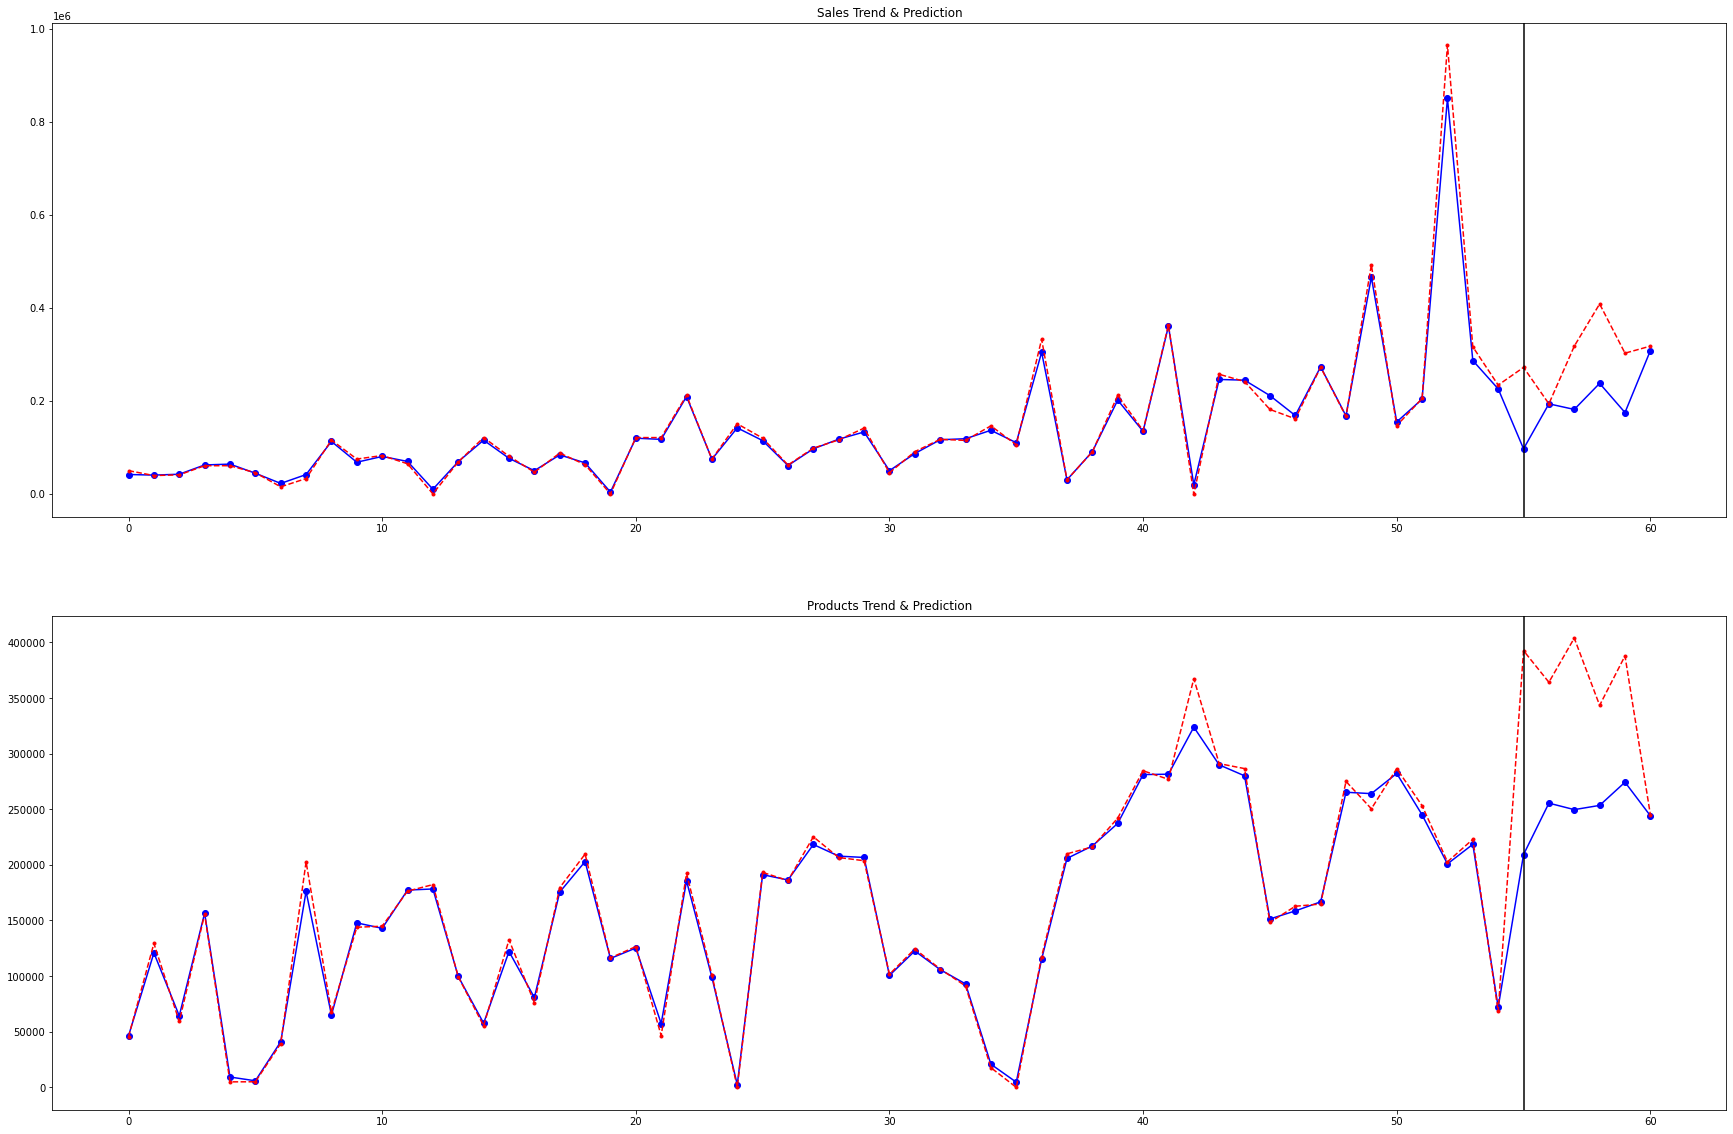

In [15]:
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.title("Sales Trend & Prediction")
plt.plot(sales_Y_, color='blue', marker='o')
plt.plot(sales_Y_hat_, color='red', linestyle='dashed', marker='.')
plt.axvline(sale_train.shape[0], c='k')
plt.subplot(2,1,2)
plt.title("Products Trend & Prediction")
plt.plot(products_Y_, color='blue', marker='o')
plt.plot(products_Y_hat_, color='red', linestyle='dashed', marker='.')
plt.axvline(product_train.shape[0], c='k')

In [16]:
d_test  = d_set[divmod(d_set['Week'], 100)[0] == 2021]
d_train = d_set[divmod(d_set['Week'], 100)[0] != 2021]

In [17]:
model_inven=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.1, gamma=0, subsample=0.75,
                                 colsample_bytree=1, max_depth=5)#, tree_method='gpu_hist', gpu_id=0)


In [22]:
inven_train_x_col = list(['Week']+sales_col+product_col)
inven_train_y_col = ['Inven']

In [23]:
real_inven, fcst_inven, inven_Y_, inven_Y_hat_, inven_prev, inven_hat = run_model_(model_inven, 
                                                                                 d_train[inven_train_x_col], np.array(d_train[inven_train_y_col]).reshape(-1),
                                                                                 d_test[inven_train_x_col], np.array(d_test[inven_train_y_col]).reshape(-1))

 Sales Mean Average => Train :  55.8027315 / Test : 67.6132705


 Real Inventory Mean Average : 98.4839635
 Forecst Inventory Mean Average : 56.5080495


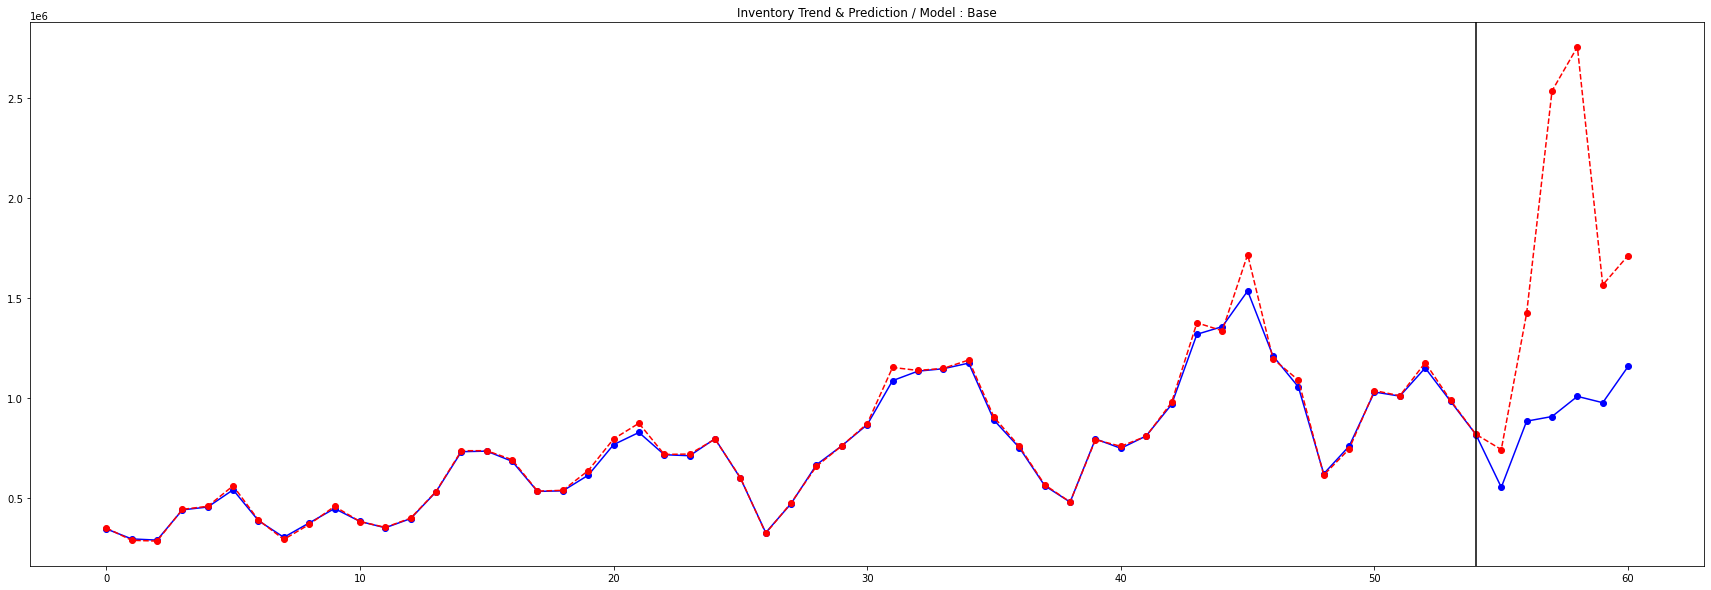

In [26]:
print(" Real Inventory Mean Average : %f5"%(real_inven))
print(" Forecst Inventory Mean Average : %f5"%(fcst_inven))

plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction / Model : Base")
plt.plot(inven_Y_, color='blue', marker='o')
plt.plot(inven_Y_hat_, color='red', linestyle='dashed', marker='o')
plt.axvline(len(inven_prev)-1, c='k')

In [31]:
d_train

,Week,5xxx,3xxC,3xxT,Inven,WW_x,Sale,Var_Sale_1,Var_Sale_2,Var_Sale_3,...,Prev_Product_4,Prev_Product_5,Prev_Product_6,Prev_Product_7,Prev_Product_8,Prev_Product_9,Prev_Product_10,Prev_Product_11,Prev_Product_12,WW_y
0,201914,6048,286759,58304,351111,201914,49896,60480,60480,60480,...,172560,8407,-999,-999,-999,-999,-999,-999,126495,201914
1,201915,30240,197944,60866,289050,201915,39312,75600,75600,75600,...,33413,172560,8407,-999,-999,-999,-999,-999,-999,201915
2,201916,45360,185295,54443,285098,201916,40845,54000,75600,75600,...,-999,33413,172560,8407,-999,-999,-999,-999,-999,201916
3,201920,15120,336055,92713,443888,201920,60480,66300,66300,90720,...,59201,129345,45535,-999,-999,33413,172560,8407,-999,201920
4,201922,30240,285308,143658,459206,201922,60480,120960,120960,151200,...,117902,87864,59201,129345,45535,-999,-999,33413,172560,201922
5,201926,15120,347889,198642,561651,201926,45360,60480,60480,60480,...,4922,56465,155630,-999,117902,87864,59201,129345,45535,201926
6,201928,45189,166426,178630,390245,201928,15120,60480,60480,60480,...,141358,143140,4922,56465,155630,-999,117902,87864,59201,201928
7,201930,15327,247017,31133,293477,201930,32886,75600,75600,90720,...,4995,-999,141358,143140,4922,56465,155630,-999,117902,201930
8,201931,15120,247017,106355,368492,201931,115668,120960,241920,241920,...,183125,4995,-999,141358,143140,4922,56465,155630,-999,201931
9,201934,15876,282044,160755,458675,201934,74811,75600,60480,60480,...,202743,-999,39333,183125,4995,-999,141358,143140,4922,201934
